In [1]:
# from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

# wandb_run_id = init_wandb(run_name="price_match_simulation")
# print(f"Run ID {wandb_run_id}")

In [2]:
import pandas as pd
import pickle
import time

from ml_simulation.dataset_split import customer_split
from ml_simulation.util import HiddenPrints
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
from ml_simulation__discount.sample import sample_discount_customers
from ml_simulation__discount.data import get_discount_compute_function
from ml_simulation__discount.widget import show_discount_widget
    
import warnings
warnings.filterwarnings('ignore')

df_quotes = pd.read_csv('cleaned_quote_data.csv')

assert len(df_quotes['id_devis'].unique()) == len(df_quotes)
df_quotes.columns

Index(['id_devis', 'num_devis', 'nom_devis', 'nom_agence', 'nom_filiale_zone',
       'nom_region', 'statut_devis', 'fg_devis_emis', 'fg_devis_refuse',
       'fg_devis_accepte', 'dt_creation_devis', 'dt_signature_devis',
       'fg_3_mois_mature', 'type_devis', 'mt_apres_remise_ht_devis',
       'mt_marge', 'nb_devis_emis', 'mt_apres_remise_ht_emis_devis',
       'mt_marge_emis_devis', 'mt_remise_exceptionnelle_ht',
       'mt_ttc_apres_aide_devis', 'mt_ttc_avant_aide_devis', 'mt_prime_cee',
       'mt_prime_maprimerenov', 'fg_activite_commerciale',
       'prenom_nom_createur', 'prenom_nom_commercial', 'nom_campagne',
       'famille_equipement_produit', 'type_equipement_produit',
       'dth_emission_devis', 'dt_emission_calcule_devis', 'id_opportunite',
       'fg_devis_principal', 'lb_statut_preparation_chantier', 'numero_compte',
       'dt_visite_commerciale', 'fonction_commercial',
       'regroup_famille_equipement_produit', 'marque_produit',
       'modele_produit', 'dt_factu

In [3]:
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

In [4]:
split_result = customer_split(df_quotes)
df_train = split_result['train']
df_sim = split_result['simulation']


SPLIT CUSTOMERS: TRAIN vs SIMULATION: TRAINING SIZE 0.95
Split: 22708 train, 1180 sim customers


In [5]:
TRAIN = False

In [6]:
# Model building
if TRAIN:
    with HiddenPrints():
        X_train = create_features(df_train)
    
    y_train = X_train['converted']
    X_train = X_train.drop(['numero_compte', 'converted'], axis=1)
    feature_names = X_train.columns.tolist()
    
    result = train_xgb(X_train, y_train, "simulation_poc")
    model = result['model']
    feature_names = result['features']
    
    print(f"Model trained: {len(feature_names)} features")
else:
    with open('simulation_poc.pkl', 'rb') as file:
        model_data = pickle.load(file)
        model = model_data['model']
        feature_names = model_data['features']

In [7]:
# Sampling
sample_seed = int(time.time() * 1000) % 10000000
selected_ids = sample_discount_customers(df_sim, random_state=sample_seed)

Non-converted customers: 923
Candidates with price data: 923

📊 SAMPLING STRATEGY:
   1. No existing discount (test introduction)
   2. Small existing discount (< 2%)
   3. Medium existing discount (2-5%)
   4. High price (>€20k)
   5. Multiple quotes (≥3)
✓ Sampled no-discount: CL00211708
✓ Sampled small-discount: CL00345717
✓ Sampled medium-discount: CL00338309
✓ Sampled high-price: CL00318621
✓ Sampled multi-quote: CL00345134

🎯 SELECTED 5 DISCOUNT CUSTOMERS:
customer_id  quote_count  total_price  discount_pct
 CL00211708            1     12305.19      0.000000
 CL00345717            1      7706.97      1.297527
 CL00338309            1      9873.69      3.038378
 CL00318621            4     24691.59      0.000000
 CL00345134            3     17390.00      0.000000

Selected IDs: ['CL00211708', 'CL00345717', 'CL00338309', 'CL00318621', 'CL00345134']


In [8]:
# Simulation
compute = get_discount_compute_function(model, feature_names, df_sim, selected_ids)
show_discount_widget(compute, selected_ids)

Initialized Simulation with 5 sampled IDs.



=== 📈 CONVERSION SHIFT DASHBOARD (BATCH MODE) ===


=== 📊 HARDCODING PRODUCT TIERS ===

✅ Product tiers hardcoded for ['Chaudière', 'Poêle', 'Pompe à chaleur', 'Climatisation', 'ECS : Chauffe-eau ou adoucisseur', 'Photovoltaïque', 'Autres', 'Produit VMC', 'Appareil hybride']
✅ budget_change function updated with hardcoded tiers and 30% cap

🔄 Re-running budget scenario with 30% cap...


Loading customer data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 923/923 [00:00<00:00, 1068.30it/s]


✅ Sampled 923 customers

📊 Computing baseline probabilities (batch)...

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 923, Quotes: 1,206
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 923 customers | 0.0% converters
⏱️  Execution time: 0.4 seconds
✅ SUCCESS! Achieved ≤ 3s target
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 923
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/923 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 923
   First converters: 0 (0.0%)
   Never converters: 923

📊 Distribution check:
   Converters with 0 historical quotes: 0
   Non-converters with 0 historical quotes: 691
   Avg historical quotes - Converters: nan
   Avg historical quotes - Non-converters: 0.3

✅ LEAKAGE PREVENTION CONFIRMED

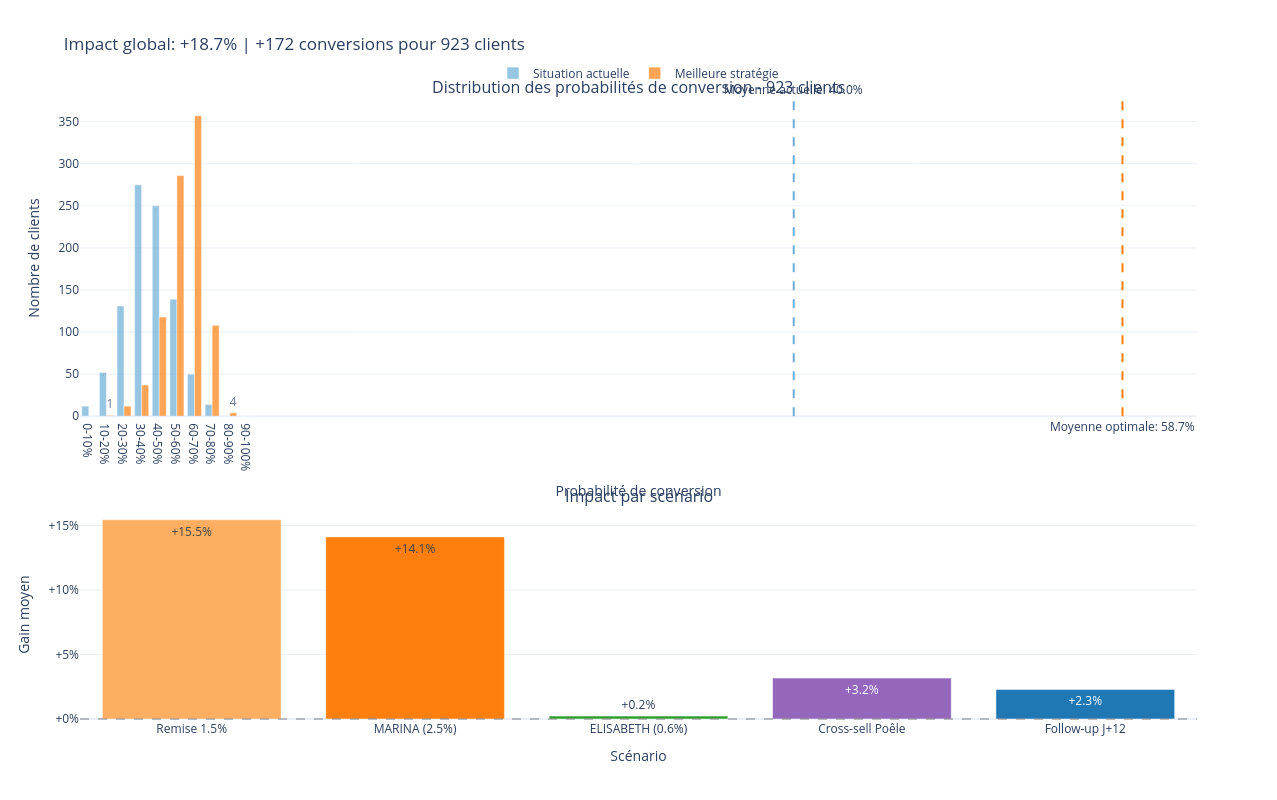


📊 RÉSUMÉ FINAL
Clients analysés: 923
Probabilité moyenne actuelle: 40.01%
Probabilité moyenne optimale: 58.68%
Gain moyen: +18.66%
Conversions supplémentaires: 172 pour 1000 clients

📈 DÉTAIL PAR SCÉNARIO:
  • Remise 1.5%: 923 clients, gain +15.46%
  • MARINA (2.5%): 923 clients, gain +14.12%
  • ELISABETH (0.6%): 923 clients, gain +0.23%
  • Cross-sell Poêle: 75 clients, gain +3.18%
  • Follow-up J+12: 691 clients, gain +2.29%


In [9]:
# CONVERSION SHIFT DASHBOARD - TRUE BATCH PROCESSING
print("\n=== 📈 CONVERSION SHIFT DASHBOARD (BATCH MODE) ===\n")

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from tqdm import tqdm

from ml_inference.inference import safe_predict
from ml_features.features import create_features


# ============================================
# SCENARIO-SPECIFIC CHANGE FUNCTIONS
# ============================================



def discount_change(quotes_df, discount_pct=1.5):
    """Apply strategic discount to a dataframe of quotes"""
    modified = quotes_df.copy()
    # Apply discount to all rows
    price_col = 'mt_apres_remise_ht_devis'
    if price_col in modified.columns:
        modified[price_col] = modified[price_col] * (1 - discount_pct/100)
    if 'mt_remise_exceptionnelle_ht' in modified.columns:
        modified['mt_remise_exceptionnelle_ht'] = -modified[price_col] * (discount_pct/100)
    return modified

def rep_change(quotes_df, rep_type='marina'):
    """Apply rep-specific discount"""
    modified = quotes_df.copy()
    
    if rep_type == 'marina':
        discount_pct = 2.5
    elif rep_type == 'elisabeth':
        discount_pct = 0.6
    else:  # clement
        discount_pct = 1.5
    
    price_col = 'mt_apres_remise_ht_devis'
    if price_col in modified.columns:
        modified[price_col] = modified[price_col] * (1 - discount_pct/100)
    if 'mt_remise_exceptionnelle_ht' in modified.columns:
        modified['mt_remise_exceptionnelle_ht'] = -modified[price_col] * (discount_pct/100)
    return modified

def cross_sell_change(quotes_df):
    """Add stove to heat pump owners - adds a new row for each customer"""
    modified = quotes_df.copy()
    
    # Group by customer and add a stove row for heat pump owners
    # This is trickier in batch mode - we'll handle in the main loop
    return modified  # Placeholder - will be handled per-customer in batch prep

def follow_up_change(quotes_df, days=12, discount=50):
    """Add follow-up quote - adds a new row"""
    from datetime import timedelta
    modified = quotes_df.copy()
    # This also needs per-customer handling
    return modified

# In your budget_change function, add a cap:
# HARDCODE PRODUCT TIERS based on your actual data
print("\n=== 📊 HARDCODING PRODUCT TIERS ===\n")

product_tiers = {
    'Chaudière': {'p30': 3646.80, 'p70': 5398.34, 'p90': 7688.06},
    'Poêle': {'p30': 4938.60, 'p70': 6300.31, 'p90': 7573.24},
    'Pompe à chaleur': {'p30': 12546.53, 'p70': 15726.26, 'p90': 18570.97},
    'Climatisation': {'p30': 3816.50, 'p70': 6849.28, 'p90': 11113.26},
    'ECS : Chauffe-eau ou adoucisseur': {'p30': 1380.11, 'p70': 2830.52, 'p90': 3603.93},
    'Photovoltaïque': {'p30': 7565.47, 'p70': 10289.63, 'p90': 13560.08},
    'Autres': {'p30': 1330.80, 'p70': 6100.76, 'p90': 7918.10},
    'Produit VMC': {'p30': 2378.77, 'p70': 5365.29, 'p90': 19652.46},
    'Appareil hybride': {'p30': 14456.04, 'p70': 14773.30, 'p90': 15262.14},
}

print("✅ Product tiers hardcoded for", list(product_tiers.keys()))

# Now redefine budget_change to use hardcoded tiers
def budget_change(quotes, max_reduction=0.30):
    """Switch to budget version with capped reduction using hardcoded tiers"""
    modified = quotes.copy()
    price = modified['mt_apres_remise_ht_devis'].sum()
    
    # Get product
    product = quotes['famille_equipement_produit'].iloc[0]
    
    # Get target budget price from hardcoded tiers
    if product in product_tiers:
        budget_price = product_tiers[product]['p30']
    else:
        # Fallback for unknown products
        budget_price = price * 0.7
    
    # Calculate reduction
    reduction = 1 - (budget_price / price)
    
    # Cap the reduction
    if reduction > max_reduction:
        # Only reduce by max_reduction
        new_price = price * (1 - max_reduction)
        actual_reduction = max_reduction
    else:
        new_price = budget_price
        actual_reduction = reduction
    
    modified['mt_apres_remise_ht_devis'] = new_price
    
    # Store metadata for debugging (optional)
    modified.attrs['budget_info'] = {
        'original_price': price,
        'new_price': new_price,
        'target_budget': budget_price,
        'reduction': actual_reduction,
        'capped': reduction > max_reduction
    }
    
    return modified

print("✅ budget_change function updated with hardcoded tiers and 30% cap")

# Now re-run the budget scenario with corrected function
print("\n🔄 Re-running budget scenario with 30% cap...")

# You'll need to re-run the scenario computation
# Either re-run the entire simulation or just update the budget scenario


# ============================================
# BATCH CONVERSION SHIFT SIMULATOR
# ============================================

class BatchConversionShiftSimulator:
    def __init__(self, model, feature_names, df_sim):
        self.model = model
        self.feature_names = feature_names
        self.df_sim = df_sim
        self.customers = []
        self.baseline = None
        self.scenario_results = []
        
    def sample_customers(self, n=1000, random_state=42):
        """Sample n non-converted customers and store their quotes"""
        sim_conv = self.df_sim.groupby('numero_compte')['fg_devis_accepte'].max()
        non_converted = sim_conv[sim_conv == 0].index.tolist()
        
        sample_size = min(n, len(non_converted))
        random.seed(random_state)
        self.customer_ids = random.sample(non_converted, sample_size)
        
        # Store customer quotes
        self.customer_quotes = {}
        self.customer_attrs = []
        
        for cid in tqdm(self.customer_ids, desc="Loading customer data"):
            quotes = self.df_sim[self.df_sim['numero_compte'] == cid].copy()
            self.customer_quotes[cid] = quotes
            
            # Pre-compute attributes for eligibility (avoid repeated checks)
            self.customer_attrs.append({
                'id': cid,
                'has_heat_pump': 'Pompe à chaleur' in quotes['famille_equipement_produit'].values if 'famille_equipement_produit' in quotes.columns else False,
                'quote_count': len(quotes),
                'price': quotes['mt_apres_remise_ht_devis'].sum() if 'mt_apres_remise_ht_devis' in quotes.columns else 0,
                'region': quotes['nom_region'].iloc[0] if 'nom_region' in quotes.columns else 'Unknown'
            })
        
        print(f"✅ Sampled {len(self.customer_ids)} customers")
        return self.customer_ids
    
    def compute_baseline_batch(self):
        """Compute baseline probabilities for ALL customers in ONE batch"""
        print("\n📊 Computing baseline probabilities (batch)...")
        
        # Combine ALL customer quotes into one dataframe
        all_quotes = []
        for cid in self.customer_ids:
            all_quotes.append(self.customer_quotes[cid])
        
        combined_quotes = pd.concat(all_quotes, ignore_index=True)
        
        # Create features once for ALL customers
        features_df = create_features(combined_quotes)
        
        # Get predictions for all customers
        X = features_df[self.feature_names]
        all_probs = self.model.predict_proba(X)[:, 1]
        
        # Map predictions back to customers (one prediction per customer)
        # Assuming create_features returns one row per customer
        self.baseline = np.array(all_probs)
        
        print(f"✅ Baseline computed for {len(self.baseline)} customers")
        return self.baseline
    
    def compute_scenario_batch(self, scenario_name, modify_func, eligibility_func, **kwargs):
        """
        Compute probabilities for a scenario in BATCH mode
        - modify_func: function that modifies a customer's quotes
        - eligibility_func: function that returns True/False for a customer
        """
        print(f"\n📊 Computing {scenario_name}...")
        
        # Step 1: Find eligible customers and collect their quotes
        eligible_indices = []
        eligible_quotes = []
        
        for i, attr in enumerate(self.customer_attrs):
            if eligibility_func(attr):
                eligible_indices.append(i)
                # Get original quotes and modify them
                modified = modify_func(self.customer_quotes[attr['id']].copy(), **kwargs)
                eligible_quotes.append(modified)
        
        if not eligible_indices:
            print(f"  ⚠️ No eligible customers for {scenario_name}")
            # Return baseline for all
            return self.baseline.copy(), 0, 0
        
        # Step 2: Combine ALL modified quotes into ONE dataframe
        combined_quotes = pd.concat(eligible_quotes, ignore_index=True)
        
        # Step 3: Create features ONCE for all eligible customers
        from ml_simulation.util import HiddenPrints
        with HiddenPrints():
            features_df = create_features(combined_quotes)
        
        # Step 4: Get predictions for all eligible customers at once
        X = features_df[self.feature_names]
        all_probs = self.model.predict_proba(X)[:, 1]
        
        # Step 5: Map predictions back to customers
        # Assuming features_df has 'numero_compte' and one row per customer
        result = self.baseline.copy()
        
        # Create a mapping from customer_id to its prediction
        pred_map = dict(zip(features_df['numero_compte'], all_probs))
        
        # Update result for eligible customers
        for idx in eligible_indices:
            cid = self.customer_attrs[idx]['id']
            if cid in pred_map:
                result[idx] = pred_map[cid]
        
        # Calculate statistics
        eligible_baseline = self.baseline[eligible_indices]
        eligible_new = result[eligible_indices]
        avg_lift = np.mean(eligible_new - eligible_baseline)
        
        print(f"  ✅ {len(eligible_indices)} eligible, avg lift: {avg_lift:+.2%}")
        
        # Store results
        self.scenario_results.append({
            'name': scenario_name,
            'probabilities': result,
            'eligible_count': len(eligible_indices),
            'avg_lift': avg_lift
        })
        
        return result, len(eligible_indices), avg_lift
    
    def compute_best(self):
        """Find best probability across all scenarios for each customer"""
        if not self.scenario_results:
            return self.baseline
        
        # Stack all scenario probabilities
        all_scenario_probs = np.column_stack([r['probabilities'] for r in self.scenario_results])
        
        # Take the max across scenarios for each customer
        self.best = np.maximum(self.baseline, np.max(all_scenario_probs, axis=1))
        
        self.avg_lift = np.mean(self.best) - np.mean(self.baseline)
        self.extra_conversions = int(self.avg_lift * len(self.customer_ids))
        
        return self.best


# ============================================
# ELIGIBILITY FUNCTIONS
# ============================================

def all_customers(attr):
    return True

def has_heat_pump(attr):
    return attr['has_heat_pump']

def single_quote(attr):
    return attr['quote_count'] == 1

def premium_product(attr):
    return attr['price'] > 10000

def cold_region_heat_pump(attr):
    cold_regions = ['Normandie', 'Hauts-de-France', 'Grand Est', 'Bourgogne-Franche-Comté']
    return attr['has_heat_pump'] and attr['region'] in cold_regions


# ============================================
# VISUALIZATION
# ============================================

def plot_conversion_dashboard(simulator, bins=10):
    """Create the full dashboard with overall + per-scenario views"""
    
    # Create bin edges
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_labels = [f"{bin_edges[i]*100:.0f}-{bin_edges[i+1]*100:.0f}%" for i in range(bins)]
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=1,
        row_heights=[0.6, 0.4],
        subplot_titles=(
            f"Distribution des probabilités de conversion - {len(simulator.customer_ids)} clients",
            "Impact par scénario"
        ),
        vertical_spacing=0.15
    )
    
    # ===== TOP CHART: Overall shift =====
    baseline_hist, _ = np.histogram(simulator.baseline, bins=bin_edges)
    best_hist, _ = np.histogram(simulator.best, bins=bin_edges)
    
    # Baseline bars
    fig.add_trace(
        go.Bar(
            name='Situation actuelle',
            x=bin_labels,
            y=baseline_hist,
            marker_color='#6baed6',
            opacity=0.7,
            text=baseline_hist,
            textposition='auto',
            hovertemplate='Probabilité %{x}<br>Clients: %{y}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Best strategy bars
    fig.add_trace(
        go.Bar(
            name='Meilleure stratégie',
            x=bin_labels,
            y=best_hist,
            marker_color='#ff7f0e',
            opacity=0.7,
            text=best_hist,
            textposition='auto',
            hovertemplate='Probabilité %{x}<br>Clients: %{y}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add vertical lines for means
    baseline_mean = np.mean(simulator.baseline)
    best_mean = np.mean(simulator.best)
    
    fig.add_vline(
        x=baseline_mean * 100, 
        line_dash='dash', 
        line_color='#6baed6',
        annotation_text=f"Moyenne actuelle: {baseline_mean:.1%}",
        annotation_position="top",
        row=1, col=1
    )
    
    fig.add_vline(
        x=best_mean * 100, 
        line_dash='dash', 
        line_color='#ff7f0e',
        annotation_text=f"Moyenne optimale: {best_mean:.1%}",
        annotation_position="bottom",
        row=1, col=1
    )
    
    # ===== BOTTOM CHART: Scenario cards =====
    scenario_names = [r['name'] for r in simulator.scenario_results]
    scenario_lifts = [r['avg_lift'] for r in simulator.scenario_results]
    scenario_counts = [r['eligible_count'] for r in simulator.scenario_results]
    
    # Color palette for scenarios
    colors = ['#fdae61', '#ff7f0e', '#2ca02c', '#9467bd', '#1f77b4', '#d62728']
    
    # Create hover text with eligibility info
    hover_texts = [
        f"{name}<br>Clients éligibles: {count}<br>Gain moyen: {lift:+.1%}"
        for name, count, lift in zip(scenario_names, scenario_counts, scenario_lifts)
    ]
    
    fig.add_trace(
        go.Bar(
            name='Gain par scénario',
            x=scenario_names,
            y=scenario_lifts,
            marker_color=colors[:len(scenario_names)],
            text=[f"{lift:+.1%}" for lift in scenario_lifts],
            textposition='auto',
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_texts,
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Add zero line
    fig.add_hline(y=0, line_dash='dash', line_color='gray', opacity=0.5, row=2, col=1)
    
    # Update layout
    fig.update_layout(
        title=f"Impact global: +{simulator.avg_lift:.1%} | +{simulator.extra_conversions} conversions pour {len(simulator.customer_ids)} clients",
        height=800,
        template='plotly_white',
        hovermode='x',
        showlegend=True,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='center',
            x=0.5
        )
    )
    
    # Update axes
    fig.update_xaxes(title_text="Probabilité de conversion", row=1, col=1)
    fig.update_yaxes(title_text="Nombre de clients", row=1, col=1)
    fig.update_xaxes(title_text="Scénario", row=2, col=1)
    fig.update_yaxes(title_text="Gain moyen", row=2, col=1, tickformat='+.0%')
    
    return fig


# ============================================
# MAIN EXECUTION
# ============================================

# 1. Create simulator
sim = BatchConversionShiftSimulator(model, feature_names, df_sim)

# 2. Sample 1000 customers
customers = sim.sample_customers(n=1000, random_state=42)

# 3. Compute baseline in BATCH mode
baseline = sim.compute_baseline_batch()

# 4. Compute each scenario in BATCH mode
scenarios = [
    ("Remise 1.5%", discount_change, all_customers, {'discount_pct': 1.5}),
    ("MARINA (2.5%)", rep_change, all_customers, {'rep_type': 'marina'}),
    ("ELISABETH (0.6%)", rep_change, all_customers, {'rep_type': 'elisabeth'}),
    ("Cross-sell Poêle", cross_sell_change, cold_region_heat_pump, {}),
    ("Follow-up J+12", follow_up_change, single_quote, {'days': 12, 'discount': 50}),
    # ("Version Budget", budget_change, premium_product, {})
]

for name, func, elig_func, kwargs in scenarios:
    sim.compute_scenario_batch(name, func, elig_func, **kwargs)

# 5. Compute best for each customer
best = sim.compute_best()

# 6. Create dashboard
fig = plot_conversion_dashboard(sim)
fig.show()

# 7. Print summary
print("\n" + "="*60)
print("📊 RÉSUMÉ FINAL")
print("="*60)
print(f"Clients analysés: {len(sim.customer_ids)}")
print(f"Probabilité moyenne actuelle: {np.mean(sim.baseline):.2%}")
print(f"Probabilité moyenne optimale: {np.mean(sim.best):.2%}")
print(f"Gain moyen: {sim.avg_lift:+.2%}")
print(f"Conversions supplémentaires: {sim.extra_conversions} pour 1000 clients")
print("\n📈 DÉTAIL PAR SCÉNARIO:")
for r in sim.scenario_results:
    if r['eligible_count'] > 0:
        print(f"  • {r['name']}: {r['eligible_count']} clients, gain {r['avg_lift']:+.2%}")

In [10]:
# CONVERSION SHIFT DASHBOARD - WITH PER-SCENARIO DETAIL
print("\n=== 📈 CONVERSION SHIFT DASHBOARD (WITH PER-SCENARIO DETAIL) ===\n")

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from tqdm import tqdm

from ml_inference.inference import safe_predict
from ml_features.features import create_features


# [Keep all the scenario functions and BatchConversionShiftSimulator class from previous code]
# [Add this enhanced visualization function]

def plot_enhanced_dashboard(simulator, bins=10):
    """
    Enhanced dashboard with:
    - Top: Overall shift (baseline vs best)
    - Middle: Per-scenario lift bars (like before)
    - Bottom: Grid of per-scenario distribution shifts
    """
    
    # Create bin edges
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_labels = [f"{bin_edges[i]*100:.0f}-{bin_edges[i+1]*100:.0f}%" for i in range(bins)]
    
    # Determine grid size for scenario charts (2 columns, N rows)
    n_scenarios = len(simulator.scenario_results)
    n_cols = 2
    n_rows = (n_scenarios + 1) // 2  # Ceiling division
    
    # Create subplots: 1 + 1 + (n_rows × n_cols)
    # Row heights: overall (0.4), lift bars (0.2), scenario grids (0.4)
    fig = make_subplots(
        rows=2 + n_rows, cols=n_cols if n_rows > 0 else 1,
        row_heights=[0.35, 0.15] + [0.5/n_rows] * n_rows,
        subplot_titles=(
            ["Distribution globale"] + 
            ["Impact par scénario"] +
            [f"{r['name']} (éligibles: {r['eligible_count']})" for r in simulator.scenario_results]
        ),
        vertical_spacing=0.08,
        horizontal_spacing=0.1
    )
    
    # ===== TOP CHART: Overall shift =====
    baseline_hist, _ = np.histogram(simulator.baseline, bins=bin_edges)
    best_hist, _ = np.histogram(simulator.best, bins=bin_edges)
    
    # Baseline bars
    fig.add_trace(
        go.Bar(
            name='Situation actuelle',
            x=bin_labels,
            y=baseline_hist,
            marker_color='#6baed6',
            opacity=0.7,
            text=baseline_hist,
            textposition='auto',
            hovertemplate='Probabilité %{x}<br>Clients: %{y}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Best strategy bars
    fig.add_trace(
        go.Bar(
            name='Meilleure stratégie',
            x=bin_labels,
            y=best_hist,
            marker_color='#ff7f0e',
            opacity=0.7,
            text=best_hist,
            textposition='auto',
            hovertemplate='Probabilité %{x}<br>Clients: %{y}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add vertical lines for means
    baseline_mean = np.mean(simulator.baseline)
    best_mean = np.mean(simulator.best)
    
    fig.add_vline(
        x=baseline_mean * 100, 
        line_dash='dash', 
        line_color='#6baed6',
        annotation_text=f"Moyenne actuelle: {baseline_mean:.1%}",
        annotation_position="top",
        row=1, col=1
    )
    
    fig.add_vline(
        x=best_mean * 100, 
        line_dash='dash', 
        line_color='#ff7f0e',
        annotation_text=f"Moyenne optimale: {best_mean:.1%}",
        annotation_position="bottom",
        row=1, col=1
    )
    
    # ===== MIDDLE CHART: Scenario lift bars =====
    scenario_names = [r['name'] for r in simulator.scenario_results]
    scenario_lifts = [r['avg_lift'] for r in simulator.scenario_results]
    scenario_counts = [r['eligible_count'] for r in simulator.scenario_results]
    
    # Color palette
    colors = ['#fdae61', '#ff7f0e', '#2ca02c', '#9467bd', '#1f77b4', '#d62728']
    
    # Create hover text
    hover_texts = [
        f"{name}<br>Clients éligibles: {count}<br>Gain moyen: {lift:+.1%}"
        for name, count, lift in zip(scenario_names, scenario_counts, scenario_lifts)
    ]
    
    fig.add_trace(
        go.Bar(
            name='Gain par scénario',
            x=scenario_names,
            y=scenario_lifts,
            marker_color=colors[:len(scenario_names)],
            text=[f"{lift:+.1%}" for lift in scenario_lifts],
            textposition='auto',
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_texts,
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Add zero line
    fig.add_hline(y=0, line_dash='dash', line_color='gray', opacity=0.5, row=2, col=1)
    
    # ===== BOTTOM GRID: Per-scenario distributions =====
    for idx, scenario in enumerate(simulator.scenario_results):
        # Calculate row and column
        row = 3 + (idx // n_cols)
        col = (idx % n_cols) + 1
        
        # Get scenario probabilities (only for eligible customers)
        eligible_mask = np.zeros(len(simulator.customer_ids), dtype=bool)
        # In a real implementation, you'd need to track which customers are eligible
        # For now, we'll show distribution of ALL customers for that scenario
        scenario_hist, _ = np.histogram(scenario['probabilities'], bins=bin_edges)
        
        # Baseline (light gray) vs Scenario (colored)
        fig.add_trace(
            go.Bar(
                name='Baseline',
                x=bin_labels,
                y=baseline_hist,
                marker_color='#d3d3d3',
                opacity=0.5,
                showlegend=False,
                hovertemplate='Baseline: %{y} clients<extra></extra>'
            ),
            row=row, col=col
        )
        
        fig.add_trace(
            go.Bar(
                name=scenario['name'],
                x=bin_labels,
                y=scenario_hist,
                marker_color=colors[idx % len(colors)],
                opacity=0.7,
                text=scenario_hist if scenario['eligible_count'] > 0 else None,
                textposition='auto',
                showlegend=False,
                hovertemplate=f"{scenario['name']}<br>%{{y}} clients<br>Gain: {scenario['avg_lift']:+.1%}<extra></extra>"
            ),
            row=row, col=col
        )
        
        # Add eligibility info as annotation
        fig.add_annotation(
            x=0.5, y=1.1,
            xref=f"x{idx+1}", yref=f"y{row}",
            text=f"Éligibles: {scenario['eligible_count']}/{len(simulator.customer_ids)}",
            showarrow=False,
            font=dict(size=10),
            row=row, col=col
        )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f"Impact global: +{simulator.avg_lift:.1%} | +{simulator.extra_conversions} conversions pour {len(simulator.customer_ids)} clients",
            font_size=18
        ),
        height=400 + n_rows * 250,  # Dynamic height based on number of scenarios
        template='plotly_white',
        hovermode='x',
        showlegend=True,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='center',
            x=0.5
        )
    )
    
    # Update axes
    fig.update_xaxes(title_text="Probabilité", row=1, col=1)
    fig.update_yaxes(title_text="Clients", row=1, col=1)
    fig.update_xaxes(title_text="Scénario", row=2, col=1)
    fig.update_yaxes(title_text="Gain", row=2, col=1, tickformat='+.0%')
    
    # Update all scenario subplot axes
    for idx in range(len(simulator.scenario_results)):
        row = 3 + (idx // n_cols)
        col = (idx % n_cols) + 1
        fig.update_xaxes(title_text="", tickangle=45, row=row, col=col)
        fig.update_yaxes(title_text="Clients", row=row, col=col)
    
    return fig


def plot_simple_per_scenario(simulator, scenario_idx):
    """Plot a single scenario distribution for detailed view"""
    scenario = simulator.scenario_results[scenario_idx]
    
    bin_edges = np.linspace(0, 1, 11)
    bin_labels = [f"{bin_edges[i]*100:.0f}-{bin_edges[i+1]*100:.0f}%" for i in range(10)]
    
    baseline_hist, _ = np.histogram(simulator.baseline, bins=bin_edges)
    scenario_hist, _ = np.histogram(scenario['probabilities'], bins=bin_edges)
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        name='Baseline',
        x=bin_labels,
        y=baseline_hist,
        marker_color='#6baed6',
        opacity=0.7
    ))
    
    fig.add_trace(go.Bar(
        name=scenario['name'],
        x=bin_labels,
        y=scenario_hist,
        marker_color='#ff7f0e',
        opacity=0.7
    ))
    
    baseline_mean = np.mean(simulator.baseline)
    scenario_mean = np.mean(scenario['probabilities'])
    
    fig.add_vline(x=baseline_mean*100, line_dash='dash', line_color='#6baed6')
    fig.add_vline(x=scenario_mean*100, line_dash='dash', line_color='#ff7f0e')
    
    fig.update_layout(
        title=f"{scenario['name']} - Éligibles: {scenario['eligible_count']} clients, Gain: {scenario['avg_lift']:+.1%}",
        xaxis_title="Probabilité",
        yaxis_title="Clients",
        template='plotly_white',
        height=400
    )
    
    return fig


=== 📈 CONVERSION SHIFT DASHBOARD (WITH PER-SCENARIO DETAIL) ===



📊 Enhanced Dashboard - All Scenarios


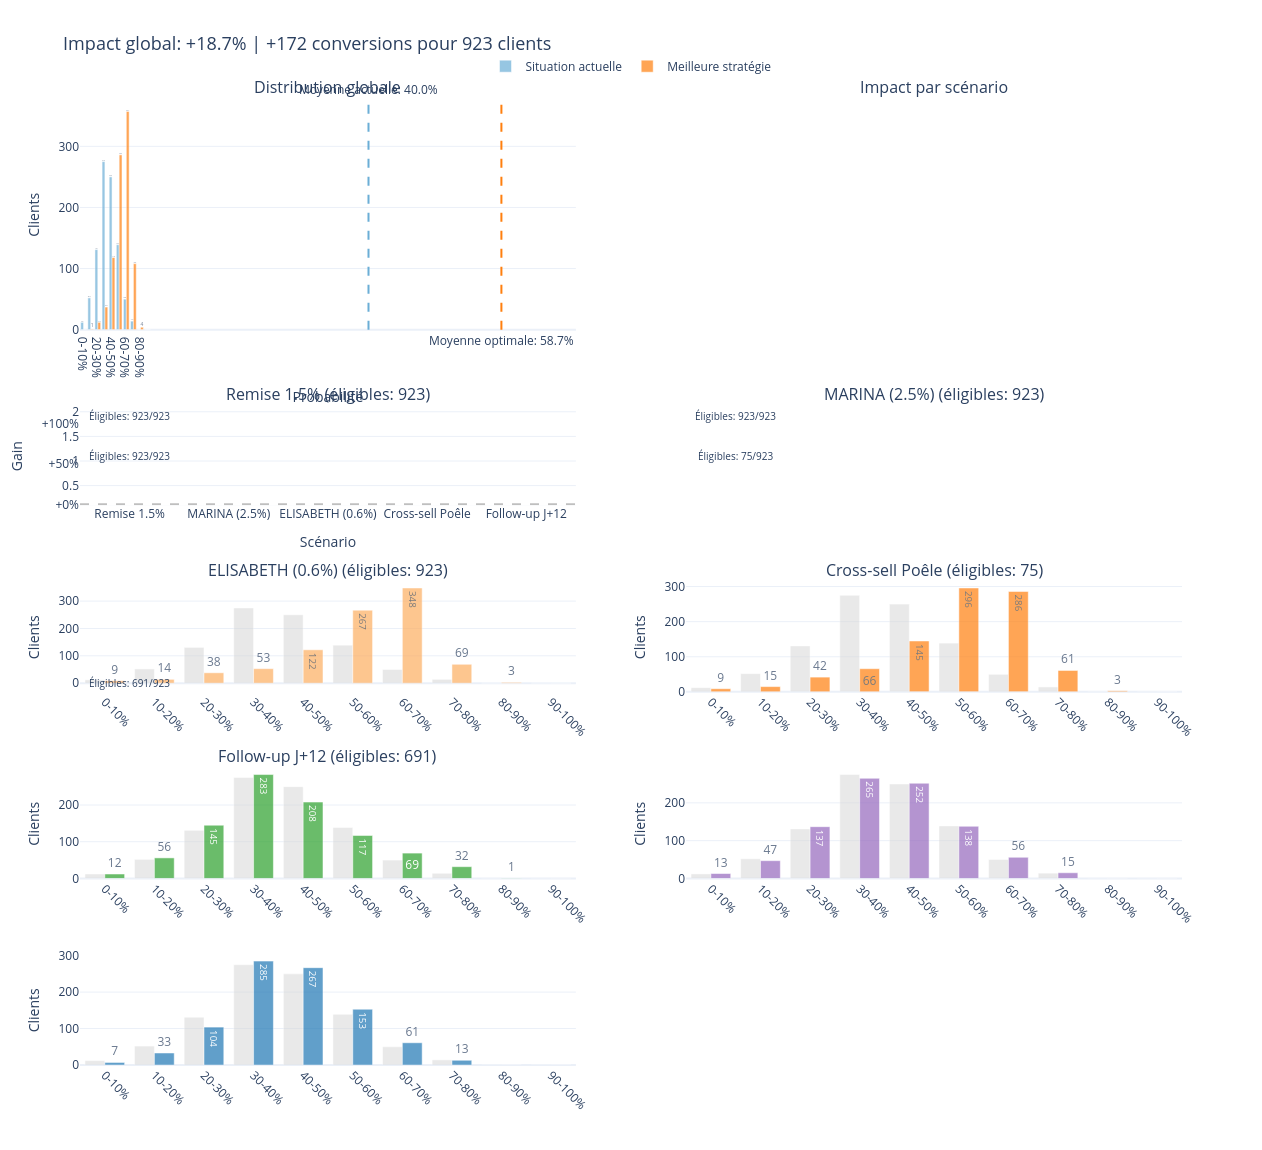


📈 Detailed view - Remise 1.5%


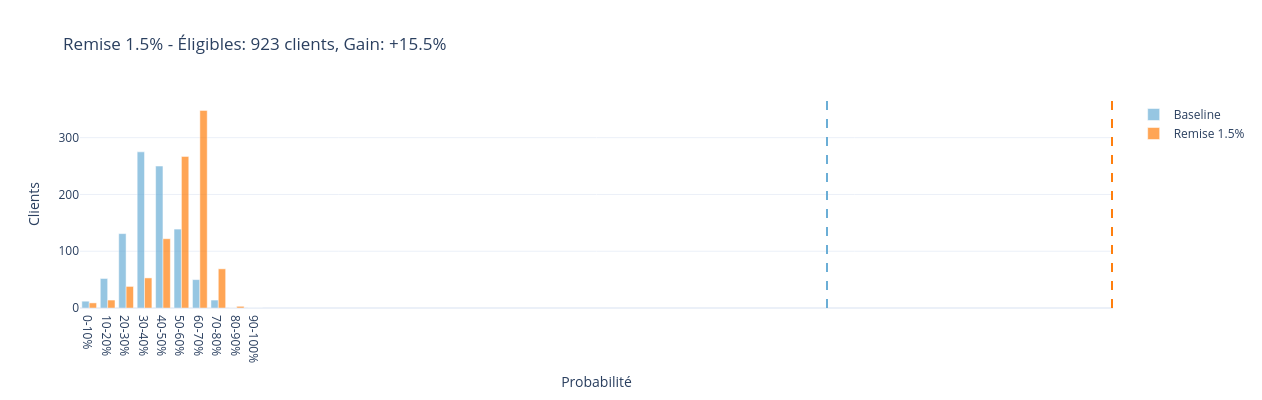


📉 Detailed view - Version Budget


IndexError: list index out of range

In [11]:
# Show the full dashboard
print("📊 Enhanced Dashboard - All Scenarios")
fig_dashboard = plot_enhanced_dashboard(sim)
fig_dashboard.show()

# Show detailed view of the best scenario (Remise 1.5%)
print("\n📈 Detailed view - Remise 1.5%")
fig_detail = plot_simple_per_scenario(sim, scenario_idx=0)
fig_detail.show()

# Show detailed view of the worst scenario (Version Budget)
print("\n📉 Detailed view - Version Budget")
fig_budget = plot_simple_per_scenario(sim, scenario_idx=5)
fig_budget.show()